In [ ]:
# ..... batch effects in data at each time point ..... #

In [2]:
library(Seurat)
library(batchelor)
library(dplyr)
library(bluster)
library(pheatmap)

In [15]:
scnew = readRDS('stage21_integrated_cca.rds')

In [16]:
scnew2 = CreateSeuratObject(counts = LayerData(scnew, assay = 'RNA', layer = 'counts'),
                            meta.data = scnew@meta.data)

scnew2 <- NormalizeData(object = scnew2, normalization.method = "LogNormalize", scale.factor = 10000)
scnew2 <- FindVariableFeatures(scnew2)
scnew2 <- ScaleData(scnew2)
scnew2 <- RunPCA(scnew2, npcs = 30)

# cluster the data
scnew2 <- FindNeighbors(scnew2, dims = 1:15, k = 30)
scnew2 <- FindClusters(object = scnew2, resolution = 0.5, verbose = FALSE)

# run umap
scnew2 <- RunUMAP(object = scnew2, dims = 1:15, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  LOC101953694, LOC101937984, LOC122173241, HMGB1, MKI67, LOC101937130, BPGM, LOC101936573, TAFA2, LOC122173014 
	   LOC101952834, LOC101933106, LOC101940697, TOP2A, SLC25A21, LOC101934193, SORBS2, SMC2, LOC101942328, LOC101942678 
	   LOC101935600, TTK, CENPE, ASPM, LOC101937396, SPC25, DLGAP5, LOC101940151, LOC101938784, LOC101938513 
Negative:  RBMS3, PDE3A, ARHGAP6, IQSEC1, TCF4, DISP1, MAGI2, PRKG1, COL5A1, ZCCHC24 
	   POSTN, PTPRF, SETBP1, PTPRD, COL1A2, CALD1, CREB5, PTPRM, EBF3, SORBS1 
	   ZNF423, GRB10, ZFPM2, CDH2, EBF1, TSHZ2, EFNA5, ADGRL3, NPAS3, COL1A1 
PC_ 2 
Positive:  MYH7B, LOC101938044, MYBPC3, RYR2, TTN, ACTN2, LOC101944249, CCDC141, FGF14, MYOM2 
	   LOC101937967, SRL, PLEKHA7, LOC122174505, TRIM55, LOC101940074, CTNNA3, EPHA5, LOC101943030, FGF13 
	   LOC101932983, LOC101946413, ABCC8, OBSCN, ERBB4, MYH15, LOC101937779, RBM24, LOC112060215, L

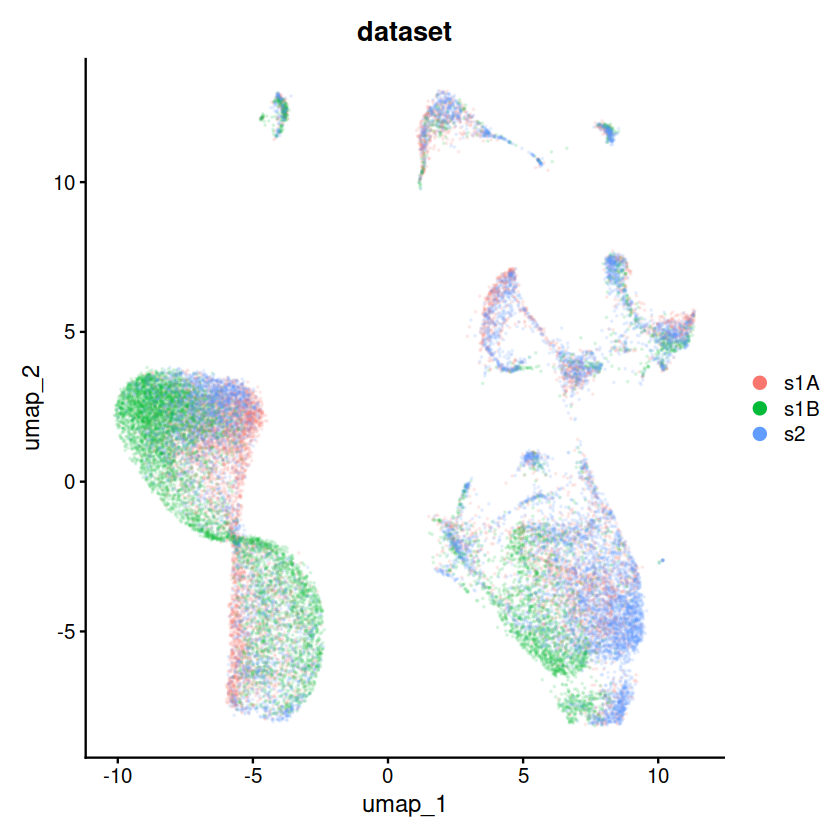

In [17]:
# plot integrated umap
tplot <- DimPlot(scnew2, reduction = "umap", group.by = "dataset")
tplot[[1]]$layers[[1]]$aes_params$alpha =  .1
tplot

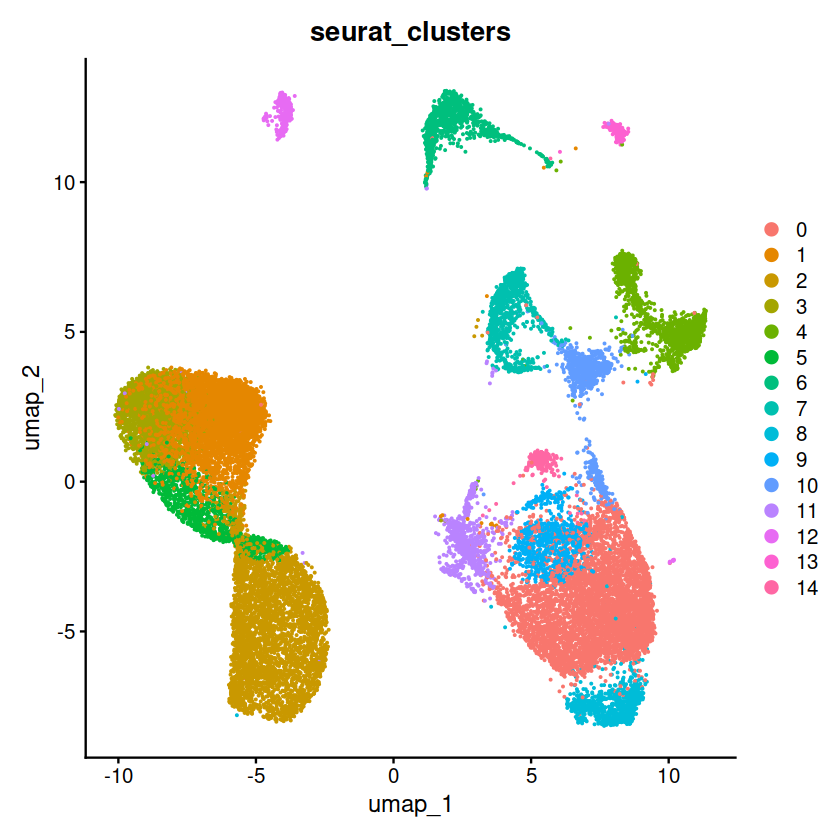

In [18]:
DimPlot(scnew2, reduction = "umap", group.by = "seurat_clusters")

In [19]:
mtd = data.frame(scnew2@reductions$umap@cell.embeddings)
mtd$merged_clusters = scnew2$seurat_clusters
mtd$before_clusters = scnew$RNA_snn_res.0.5
mtd$batch = scnew2$dataset
mtd[1:2,]

umap_1   umap_2   merged_clusters
stage21_sample1A_AAACCCAAGATAACAC-1 6.940266 3.849384 10             
stage21_sample1A_AAACCCAAGGTCCCGT-1 7.321134 3.815234 10             
                                    before_clusters batch
stage21_sample1A_AAACCCAAGATAACAC-1 7               s1A  
stage21_sample1A_AAACCCAAGGTCCCGT-1 7               s1A

In [20]:
# save cluster and umap from merging all batches
write.table(mtd, file = 'stage21_merged_batch_seurat_clusters.csv', sep = ',', row.names = T,
           col.names = T, quote = F)

In [ ]:
# ..... mixing between batches ..... #

In [ ]:
# load metadata
mtd = read.delim('stage21_merged_batch_seurat_clusters.csv', sep = ',')
unique(mtd$batch)

In [21]:
tab1 = mtd %>% group_by(merged_clusters) %>% reframe(s1 = sum(batch=='s1A'), s2 = sum(batch=='s1B'),
                                                    s3 = sum(batch=='s2'))
tab2 = as.matrix(tab1[,-1])
rownames(tab2) = unlist(tab1[,1])

In [22]:
# mixing - p-values
p.values <- clusterAbundanceTest(tab2)
p.values

0             1             2             3             4 
5.234402e-118 8.983230e-149  1.561500e-50  0.000000e+00  8.345959e-31 
            5             6             7             8             9 
1.277481e-223  5.941743e-42  5.463858e-88  3.551280e-30  6.381190e-13 
           10            11            12            13            14 
 1.577589e-42  4.311124e-11  8.550609e-06  2.906160e-05  5.730157e-18

In [23]:
# mixing - relative abundances from diff batches
rv<- clusterAbundanceVar(tab2)

# Also printing the percentage of cells in each cluster in each batch:
percent <- t(t(tab2)/colSums(tab2)) * 100 
df <- DataFrame(Batch=unclass(percent), var=rv)
df[order(df$var, decreasing=TRUE),]

DataFrame with 15 rows and 4 columns
     Batch.s1  Batch.s2  Batch.s3       var
    <numeric> <numeric> <numeric> <numeric>
3     3.96586 26.307818  0.624721  6.644941
5     3.04970 10.614004  0.479697  4.376450
7     5.78564  0.407783  5.488621  3.975519
10    3.61446  1.118490  4.796966  1.110741
6     5.72289  1.701037  5.053548  0.856187
...       ...       ...       ...       ...
9    1.995482  3.961319   3.62561  0.266030
2   19.189257 18.536642  10.91031  0.205057
13   0.727912  0.710707   1.29407  0.189899
11   2.371988  2.435046   3.96029  0.160813
12   1.330321  1.980659   1.12673  0.150420

In [ ]:
# ..... preserving biological heterogeneity ..... #
# checking mapping before and after correction

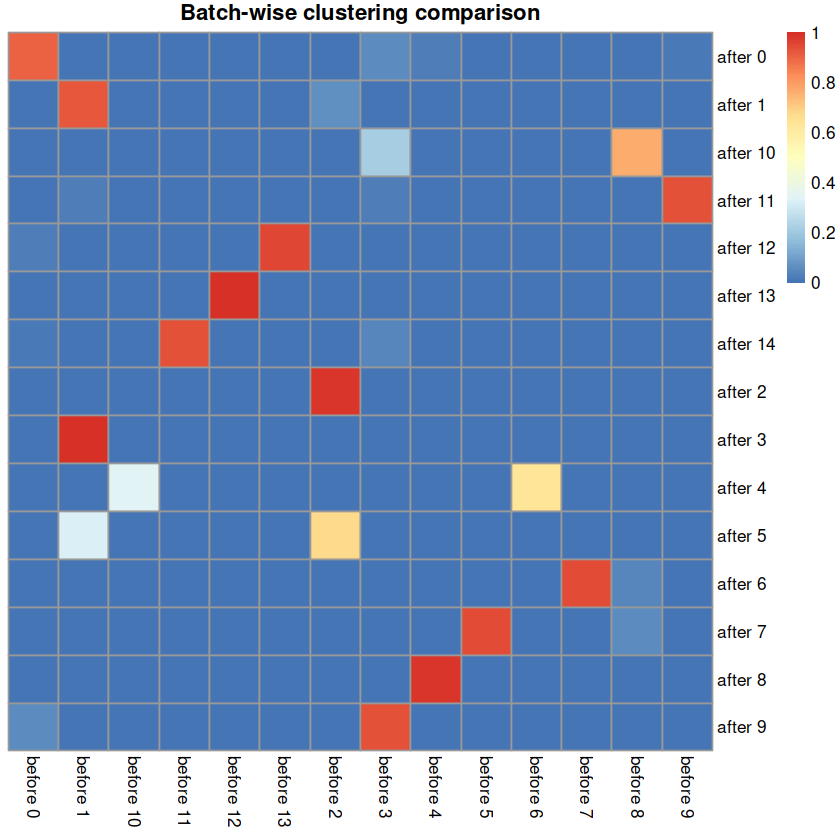

In [24]:
# For each batch:
tab4k <- nestedClusters(ref=paste("before", mtd$before_clusters[scnew2$dataset=='s2']),
                        alt=paste("after", mtd$merged_clusters[scnew2$dataset=='s2']))
pheatmap(tab4k$proportions, cluster_row=FALSE, cluster_col=FALSE,
                   main="Batch-wise clustering comparison")

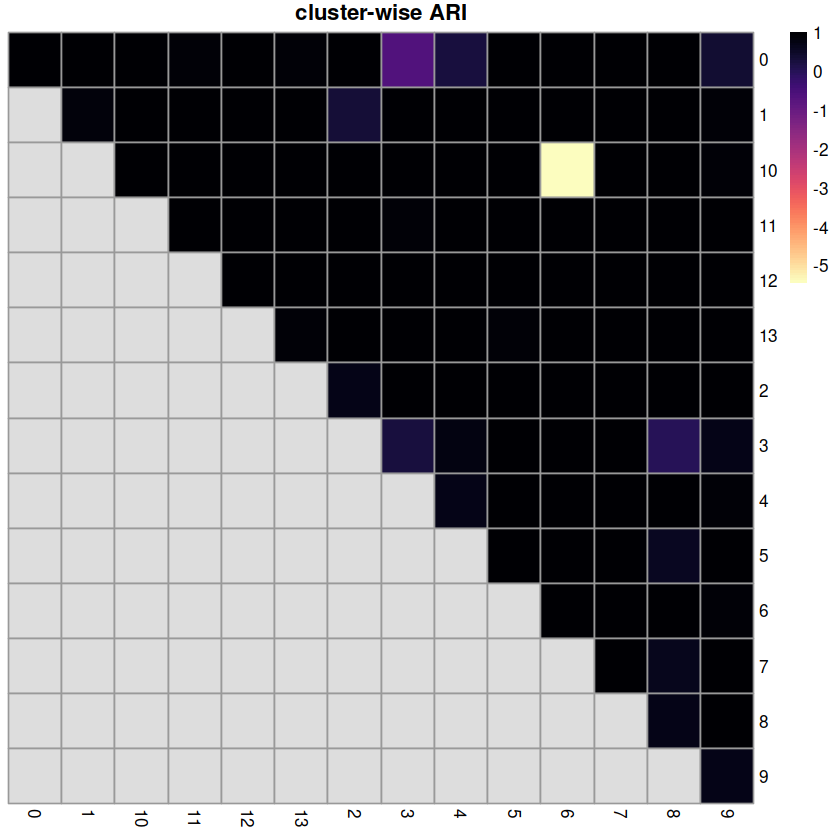

In [25]:
# For each batch - ARI per cluster
tab_ari <- pairwiseRand(mtd$before_clusters[scnew2$dataset=='s2'],
                       mtd$merged_clusters[scnew2$dataset=='s2'])
pheatmap(tab_ari, cluster_row=FALSE, cluster_col=FALSE,
    col=rev(viridis::magma(100)), main="cluster-wise ARI")